In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [21]:
df = pd.read_csv("netflix_reviews_cleaned.csv")

# Tampilkan struktur awal data
df.head()


,userName,score,content,final_review
0,Muqaffi,3,"Tolong tambah kecepatan pemutaran 0,8 - 1,2 sa...",tolong cepat putar butuh nonton sepel
1,Rafael,1,"Ini udah 5 hari gua nonton loading mulu, udah ...",udah gua nonton loading mulu udah coba pake da...
2,Iqbal Mushodik,1,"diperbaiki lagi min, udah 2 minggu one piece g...",baik min udah minggu one piece rilis sumpah males
3,Aisa Muhammad,5,akhir nya bisa nonton Boboiboy baraju,nya nonton boboiboy baraju
4,fa rel,1,cara masuknya gimana anj**g,masuk gimana anj


In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userName      999 non-null    object
 1   score         999 non-null    int64 
 2   content       999 non-null    object
 3   final_review  978 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [25]:
df = df[['userName', 'content', 'score']]
df.dropna(subset=['content'], inplace=True)

print("Jumlah data:", len(df))
df.head()


Jumlah data: 999


/tmp/ipython-input-2895266719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['content'], inplace=True)


,userName,content,score
0,Muqaffi,"Tolong tambah kecepatan pemutaran 0,8 - 1,2 sa...",3
1,Rafael,"Ini udah 5 hari gua nonton loading mulu, udah ...",1
2,Iqbal Mushodik,"diperbaiki lagi min, udah 2 minggu one piece g...",1
3,Aisa Muhammad,akhir nya bisa nonton Boboiboy baraju,5
4,fa rel,cara masuknya gimana anj**g,1


In [26]:
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = []
    for word in text.split():
        if word not in stopwords and len(word) > 3:
            tokens.append(stemmer.stem(word))
    return ' '.join(tokens)


In [27]:
df['cleaned'] = df['content'].apply(preprocess_text)
df[['content', 'cleaned']].head()


,content,cleaned
0,"Tolong tambah kecepatan pemutaran 0,8 - 1,2 sa...",tambah cepat putar perlu butuh nonton sepel
1,"Ini udah 5 hari gua nonton loading mulu, udah ...",udah hari nonton loading mulu udah coba pake d...
2,"diperbaiki lagi min, udah 2 minggu one piece g...",baik udah minggu piece rilis sumpah jadi males
3,akhir nya bisa nonton Boboiboy baraju,akhir nonton boboiboy baraju
4,cara masuknya gimana anj**g,cara masuk gimana


In [28]:
def label_sentiment(score):
    if score >= 4:
        return 'Positif'
    elif score == 3:
        return 'Netral'
    else:
        return 'Negatif'

df['sentimen'] = df['score'].apply(label_sentiment)
df[['score', 'sentimen']].head()


,score,sentimen
0,3,Netral
1,1,Negatif
2,1,Negatif
3,5,Positif
4,1,Negatif


In [29]:
vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=5
)

X = vectorizer.fit_transform(df['cleaned'])

print("Shape TF-IDF:", X.shape)


Shape TF-IDF: (999, 293)


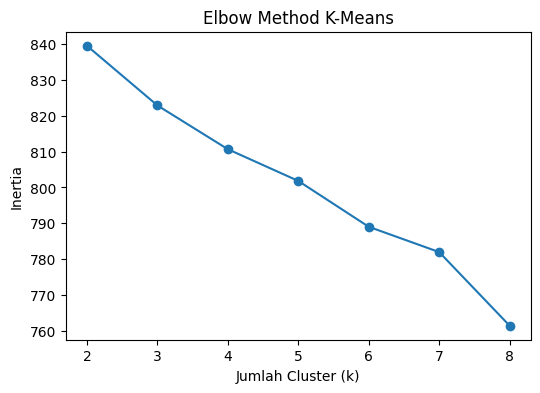

In [30]:
inertia = []
K = range(2, 9)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method K-Means')
plt.show()


In [31]:
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

df['cluster'] = kmeans.fit_predict(X)

df['cluster'].value_counts()


,count
cluster,
1,735
0,222
2,42


In [32]:
terms = vectorizer.get_feature_names_out()

for i in range(3):
    top_terms = kmeans.cluster_centers_[i].argsort()[-10:][::-1]
    print(f"\nCluster {i} - Topik Utama:")
    print(", ".join(terms[t] for t in top_terms))



Cluster 0 - Topik Utama:
login, daftar, susah, masuk, ribet, udah, akun, aplikasi, bayar, email

Cluster 1 - Topik Utama:
film, netflix, nonton, aplikasi, bayar, langgan, banget, padahal, mantap, banyak

Cluster 2 - Topik Utama:
bagus, film, banget, sangat, kualitas, sekali, suka, aplikasi, mantap, netflix
